In [3]:
!pip install setuptools==58
!pip install -e ../

Obtaining file:///fintech-optimization-pvc/projects/wankun01/playground/vit_pretrained_pytorch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pytorch-pretrained-vit


In [1]:
import os
import torch
import torch.nn as nn
from pytorch_pretrained_vit import ViT_CLS_FT, ViT
from predtools.functions import make_fewshots_pred_ft_all, make_fewshots_pred_noft, make_fewshots_pred_ft
from predtools.functions import extract_feature_vector
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Load the model's state_dict (weights and biases)
state_dict = torch.load("../save_models/model_ft.pth")
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
nclasses = 4
data_root = "../imgs"


In [5]:
# make a new vit
vit_ft = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
vit_ft.to(device)
# make a new cls head with preset parameters
cls_head_ft = nn.Linear(768, nclasses)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head_ft.weight = nn.Parameter(torch.rand(nclasses, 768))
    cls_head_ft.bias = nn.Parameter(torch.rand(1, 4))
print("init values for cls head:")
print(cls_head_ft.bias.shape)
print(cls_head_ft.weight.shape)
# make a combined model using above two
model = ViT_CLS_FT(pretrained_vit_body=vit_ft, cls_head=cls_head_ft)
model.load_state_dict(state_dict)
model.to(device)

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/1e9, "G")

repr size None
None True
pre_logits_size 768


Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth


  0%|          | 0.00/331M [00:00<?, ?B/s]

Loaded pretrained weights.
init values for cls head:
torch.Size([1, 4])
torch.Size([4, 768])
0.69626368 G


In [18]:
ground_truth = {0:"public greenary", 1:"one housing", 2:"centerized housing", 3:"parking lot"}
test_img_path = os.path.join(data_root, "0NebjQvCnjUzCJ0iSuXC8g.jpg")

In [19]:
# define transforms
tsfm = transforms.Compose([transforms.Resize(size=(384, 384)), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

(-0.5, 639.5, 479.5, -0.5)

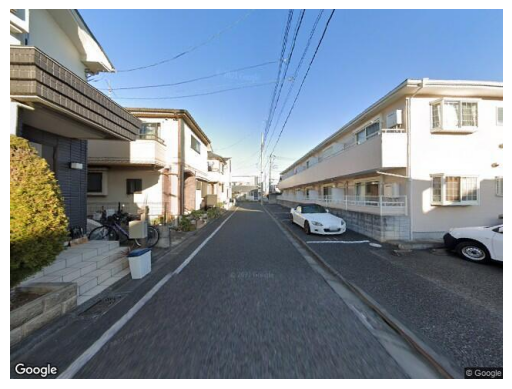

In [20]:
img_path = os.path.join(test_img_path)
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')

In [21]:
# make_fewshots_pred_noft(test_img_path, ground_truth=ground_truth)
# make_fewshots_pred_ft(test_img_path, ground_truth=ground_truth, model=model, tsfm=tsfm, device=device)
make_fewshots_pred_ft_all(test_img_path, ground_truth=ground_truth,  model_ft=model, tsfm=tsfm, device=device, show=True)

--------------------
prediction with "vit + mlp" finetuning
public greenary:14.5804%
one housing:13.5552%
centerized housing:21.2894%
parking lot:50.5750%
--------------------


# applications ideas
1. Land Use Classification: Use of deep learning algorithms to classify land use patterns in urban areas based on street view images, including the identification of residential, commercial, industrial, and public land uses. --> then how to link other economic elements ? 
    * here we can manually to set fraction of land use types in support set to improve the performance. few-shots learning enable us to do so. 
    * then apply the model to test dataset, obtaining the label for test dataset --> model performance check with annotated dataset, acc, mcc, etc.
    * we can run clustering using the feature before / after the finetuning to compare the improvements.
    * mapping the predicted classes into clustering results and estimate the concentration of data, see if predicted labels can replace clustering.
    
    **The advantages of the method are: (1) it does not require large annotated data or dependence on many human-based evaluation to achieve the extraction of interested urban elements. (2) it enables a freedom to choose the related urban elements in images that are most suitable for downstream social analysis. (3) it improves quality for feature extraction on certain sentiment of images, which can be used in fusion analysis. **
    
2. there are some links that can be created from land use to socioeconomics:
    * Land use research results can be applied in socioeconomics by examining the relationship between the built environment and social and economic outcomes. This can be done in several ways:

        ** Housing Affordability: Land use patterns, including the availability and accessibility of housing, can have a significant impact on housing affordability and the economic well-being of households.

        ** Access to Jobs: Land use patterns can affect access to employment opportunities, including the proximity of employment centers and the availability of transportation options.

        ** Retail Accessibility: The availability of retail and commercial services can be influenced by land use patterns, including the proximity of commercial areas and the availability of transportation options.

        ** Environmental Quality: Land use patterns can affect the quality of the built and natural environment, including the availability of green spaces, access to fresh air and clean water, and exposure to environmental hazards.

        ** Health Outcomes: Land use patterns can affect health outcomes, including access to healthy food options, exposure to environmental hazards, and the availability of physical activity opportunities.

        **By understanding the relationships between land use patterns and socioeconomics, urban planners and policymakers can make informed decisions about the built environment and its impact on the well-being of communities. This information can be used to guide the development of policies and programs that support healthy, sustainable, and equitable communities**.

# Examples of land use classification to socioeconomics analysis:
## Assessing the housing attributes of different types of housing, including one-housing, centerized housing, housing with parkings, etc.

     1. extract a small support set that includes interested types of these housings and non-interested samples (as negative samples). (some classes)
     2. few-shot learning with pretraining-finetuning paradiam, validate the performance with test set, clustering match, etc.
     3. apply the model on new data images to obtain the features and predicted probablities of each class.
     4. treat the probablity of each class as its score, mapping the scores with the spatial distributions of these images to evaluate the presence of classes.
         -- we can also segment map into small cells and then map the data instead of directly mapping each data point.
     5. we can evaluate the relation between each types of housings and the economical classes and demographics of the city, for example, in a region where one-housing with cars are predominate, it is expected the main social class is mid-class with decent salary and stable family, which means they have stronger desire for good quality consumptions, higher standards for entertainment, etc. This can provide more chances for business people to provide corresponding products and services. We can link the corresponding types of facilities, such as commercial area and shopping plaza to the map to see if such statements are true. If so, such method becomes valuable in business decision makings.
     6. In addtion, obtaining other related data, such as transit facilities, distances, we can try to estimate the availablity and affordablity of housing in a region. The example could be the prediction of price range in a location using a fusion of all the features we extract from data points + housing type density + other data source (transit, population, commercial). 
